# Análisis de texto con spacy

In [1]:
import pkg_resources
import warnings

warnings.filterwarnings('ignore')

installed_packages = [package.key for package in pkg_resources.working_set]
IN_COLAB = 'google-colab' in installed_packages

/tmp/ipython-input-2396000874.py:1: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


In [2]:
!pip install -r requirements.txt

In [3]:
# RUN THIS CELL to perform standard imports:
import spacy
nlp = spacy.load('en_core_web_sm')
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import re
from textwrap import shorten
from spacy import displacy
from spacy.matcher import Matcher
from collections import Counter, defaultdict
#from collections import defaultdict
from itertools import combinations
import networkx as nx
import matplotlib.pyplot as plt

## Carga y análisis inicial del texto



In [4]:
# Increase the max_length to accommodate the large text file
# nlp.max_length = 2000000

#with open('./GameofThrones.txt') as file:
with open('./GameofThrones-mini.txt') as file:
    doc = nlp(file.read())

In [5]:
doc[:100]

A Game Of Thrones 
Book One of A Song of Ice and Fire 
By George R. R. Martin 
PROLOGUE 
"We should start back," Gared urged as the woods began to grow dark around them. "The wildlings are 
dead." 
"Do the dead frighten you?" Ser Waymar Royce asked with just the hint of a smile. 
Gared did not rise to the bait. He was an old man, past fifty, and he had seen the lordlings come and go. 

### Longitud del téxto y oraciones detectadas

In [6]:
len(doc)

212587

In [7]:
sentences = list(doc.sents)
len(sentences)

14088

Estadísticas en base a las oraciones del texto

In [8]:
sentence_lengths = [len(sent) for sent in doc.sents]

avg_len = sum(sentence_lengths) / len(sentence_lengths)
max_len = max(sentence_lengths)
min_len = min(sentence_lengths)
print(f"Longitud promedio: {avg_len:.2f}")
print(f"Longitud máxima: {max_len}")
print(f"Longitud mínima: {min_len}")

Longitud promedio: 15.09
Longitud máxima: 136
Longitud mínima: 1


Filtrar las oraciones para evitar frases muy cortas o muy largas

In [9]:
filtered_sents = [
    sent for sent in doc.sents
    if 8 <= len(sent) <= 25
]
len(filtered_sents)

9427

In [10]:
filtered_sents[10:20]

[He wished it had been later rather 
 than sooner.,
 "My mother told me that dead men sing no songs," he put in. ,
 "My wet nurse said the same thing, Will," Royce replied.,
 "Never believe anything you hear at a woman's 
 tit.,
 There are things to be learned even from the dead.",
 His voice echoed, too loud in the twilit forest. ,
 Page 1
 
 "We have a long ride before us," Gared pointed out.,
 Ser Waymar Royce glanced at the sky with disinterest.,
 "It does that every day about this time.,
 Yet it was more than 
 that.]

El archivo `GameofThrones-mini.txt` contiene varias páginas del libro *Game of Thrones*, lo que hace que no todas las oraciones detectadas tengan información útil para el análisis a realizar con el texto, por esta razón se hace necesario realizar un proceso de limpieza del texto

## Limpieza del texto

In [11]:
def remove_metadata(text):
    patterns = [
        r"^\s*PROLOGUE\s*$",
        r"^\s*EPILOGUE\s*$",
        r"^\s*CHAPTER.*$",
        r"^Page \d+.*$"
    ]
    for p in patterns:
        text = re.sub(p, "", text, flags=re.MULTILINE)
    return text

doc_clean = remove_metadata(doc.text)

In [12]:
def normalize_quotes(text):
    return (
        text.replace("“", '"')
            .replace("”", '"')
            .replace("’", "'")
            .replace("‘", "'")
    )

doc_clean = normalize_quotes(doc_clean)

In [13]:
def normalize_whitespace(text):
    text = re.sub(r"\n{2,}", "\n", text)   # múltiples saltos → uno
    text = re.sub(r"[ \t]+", " ", text)    # espacios repetidos
    return text.strip()

doc_clean = normalize_whitespace(doc_clean)

Convertir el texto nuevamente al formato requerido para análisis

In [14]:
doc_clean_nlp = nlp(doc_clean)
doc_clean_nlp[:100]

A Game Of Thrones 
Book One of A Song of Ice and Fire 
By George R. R. Martin 
"We should start back," Gared urged as the woods began to grow dark around them. "The wildlings are 
dead." 
"Do the dead frighten you?" Ser Waymar Royce asked with just the hint of a smile. 
Gared did not rise to the bait. He was an old man, past fifty, and he had seen the lordlings come and go. 
"Dead

## Comparación del texto original y el procesado

In [15]:
filtered_sents_clean = [
    sent for sent in doc_clean_nlp.sents
    if 8 <= len(sent) <= 25
]

sentences_clean = list(doc_clean_nlp.sents)

sentence_lengths_clean = [len(sent) for sent in doc_clean_nlp.sents]
avg_len_clean = sum(sentence_lengths_clean) / len(sentence_lengths_clean)
max_len_clean = max(sentence_lengths_clean)
min_len_clean = min(sentence_lengths_clean)

data = {
    "Métrica": [
        "Número total de oraciones",
        "Oraciones filtradas (8–25 tokens)",
        "Longitud promedio de oración",
        "Longitud mínima de oración",
        "Longitud máxima de oración"
    ],
    "Texto original": [
        len(sentences),
        len(filtered_sents),
        round(avg_len, 2),
        min_len,
        max_len
    ],
    "Texto limpio": [
        len(sentences_clean),
        len(filtered_sents_clean),
        round(avg_len_clean, 2),
        min_len_clean,
        max_len_clean
    ]
}

df_comparative = pd.DataFrame(data)
df_comparative

,Métrica,Texto original,Texto limpio
0,Número total de oraciones,14088.00,14073.00
1,Oraciones filtradas (8–25 tokens),9427.00,9404.00
2,Longitud promedio de oración,15.09,15.04
3,Longitud mínima de oración,1.00,1.00
4,Longitud máxima de oración,136.00,136.00


In [16]:
filtered_sents_clean = [
    sent for sent in doc_clean_nlp.sents
    if 8 <= len(sent) <= 25
]

for i in range(10, 20):
    left = shorten(filtered_sents[i].text, width=60, placeholder="...")
    right = shorten(filtered_sents_clean[i].text, width=60, placeholder="...")

    print(f"[{i}] {left:<65} | {right}")


[10] He wished it had been later rather than sooner.                   | He wished it had been later rather than sooner.
[11] "My mother told me that dead men sing no songs," he put in.       | "My mother told me that dead men sing no songs," he put in.
[12] "My wet nurse said the same thing, Will," Royce replied.          | "My wet nurse said the same thing, Will," Royce replied.
[13] "Never believe anything you hear at a woman's tit.                | "Never believe anything you hear at a woman's tit.
[14] There are things to be learned even from the dead."               | There are things to be learned even from the dead."
[15] His voice echoed, too loud in the twilit forest.                  | His voice echoed, too loud in the twilit forest.
[16] Page 1 "We have a long ride before us," Gared pointed out.        | "We have a long ride before us," Gared pointed out.
[17] Ser Waymar Royce glanced at the sky with disinterest.             | Ser Waymar Royce glanced at the sky with disint

En la oración 16 se hace evidente el resultado de la limpieza y la razón por la que las métricas generales aparentemente no cambian. A pesar de que el téxto cuenta con 300 páginas, el indicador de página se encontraba como parte de algunas oraciones.

## Análisis - tokenización - de una oración del documento

In [17]:
filtered_sents_clean[29]

Ser Waymar Royce was the youngest son of an ancient house with too many heirs.

Relación semantica entre los tokens

In [18]:
displacy.render(filtered_sents_clean[29], style="dep")

In [19]:
print("{:20}{:20}{:20}{:20}{:20}".format("Text", "POS", "dep", "lemma", "head"))
for token in filtered_sents_clean[29]:
    print(f"{token.text:{20}}{token.pos_:{20}}{token.dep_:{20}}{token.lemma_:{20}}{token.head.text:{20}}")

Text                POS                 dep                 lemma               head                
Ser                 PROPN               compound            Ser                 Royce               
Waymar              PROPN               compound            Waymar              Royce               
Royce               PROPN               nsubj               Royce               was                 
was                 AUX                 ROOT                be                  was                 
the                 DET                 det                 the                 son                 
youngest            ADJ                 amod                young               son                 
son                 NOUN                attr                son                 was                 
of                  ADP                 prep                of                  son                 
an                  DET                 det                 an                  house      

## Anñalisis en función de patrones dentro del texto

Se buscarán coincidencias con el patrón `the wall` en el texto

In [20]:
matcher = Matcher(nlp.vocab)
pattern = [{'LOWER': 'the'}, {'IS_SPACE': True}, {'LOWER': 'wall'}]
matcher.add("theWall", [pattern])

In [21]:
found_matches = matcher(doc_clean_nlp)
found_matches

[(11409623613090504156, 26838, 26841),
 (11409623613090504156, 96245, 96248),
 (11409623613090504156, 110503, 110506)]

Validación manual de las coincidencias detectadas para el patrón de entrada `theWall`

In [22]:
for sentence in filtered_sents_clean:
    for _, start, end in found_matches:
        if sentence.start <= start and sentence.end >= end:
            print(sentence.text, '\n')

Her sons could rule from the 
Wall to the mountains of Dorne. 

Tyrion found himself walking past it, toward the vast pale palisade of the 
Wall. 
 

Thousands and thousands of years ago, Brandon the Builder had raised Winterfell, and some said the 
Wall. 



# **NER**

Reconocimiento de entidades nombradas para detectar personajes, lugares, organizaciones, fechas, etc.

In [23]:
entities = [(ent.text, ent.label_) for ent in doc_clean_nlp.ents]
labels = [ent.label_ for ent in doc.ents]
Counter(labels)


Counter({'CARDINAL': 1129,
         'PERSON': 4662,
         'WORK_OF_ART': 234,
         'DATE': 478,
         'TIME': 214,
         'PRODUCT': 106,
         'ORDINAL': 200,
         'GPE': 501,
         'QUANTITY': 41,
         'ORG': 996,
         'LAW': 2,
         'LOC': 92,
         'NORP': 106,
         'FAC': 93,
         'EVENT': 11,
         'LANGUAGE': 12,
         'MONEY': 1})

Top de las entidades más frecuentes en el texto considerando el texto original y el texto procesado

In [24]:
entity_freq = Counter(ent.text for ent in doc.ents)
entity_freq_clean = Counter(ent.text for ent in doc_clean_nlp.ents)

entities_par = set(entity_freq) | set(entity_freq_clean)

rows = []

for ent in entities_par:
    rows.append({
        "Entidad": ent,
        "Original": entity_freq.get(ent, 0),
        "Limpio": entity_freq_clean.get(ent, 0),
        "Δ (Limpio-Original)": entity_freq_clean.get(ent, 0) - entity_freq.get(ent, 0)
    })

df_entities_par = pd.DataFrame(rows)

df_entities_par_sort = df_entities_par.sort_values("Original", ascending=False)
print(df_entities_par_sort.head(20).to_string(index=False))

      Entidad  Original  Limpio  Δ (Limpio-Original)
          Ned       456     462                    6
          Jon       339     341                    2
      Catelyn       283     283                    0
       Robert       237     237                    0
        Sansa       155     160                    5
         Bran       138     138                    0
          one       128     128                    0
        first       127     127                    0
   Winterfell       127     127                    0
         Arya       114     114                    0
        Stark       113     113                    0
 Littlefinger       109     110                    1
          two       103     103                    0
         Robb        90      92                    2
      Joffrey        84      84                    0
         half        82      82                    0
     Dothraki        81      81                    0
    Lannister        81      82               

## Palabras clave

El análisis con NER puede servir como apoyo a la identificación de palabras clave en función de una carácterística de interés:

**Según el contexto**

In [25]:
keywords = [
    token.lemma_
    for token in doc_clean_nlp
    if token.pos_ in ("NOUN", "PROPN", "ADJ")
    and not token.is_stop
    and token.is_alpha
]
keywords[:15]

['Game',
 'Thrones',
 'Book',
 'Song',
 'Ice',
 'Fire',
 'George',
 'Martin',
 'wood',
 'dark',
 'wildling',
 'dead',
 'dead',
 'Ser',
 'Waymar']

**Según la frecuencia de las palabras**

In [26]:
words = [
    token.lemma_.lower()
    for token in doc_clean_nlp
    if token.is_alpha and not token.is_stop
]

word_freq = Counter(words)
word_freq.most_common(20)

[('say', 1232),
 ('man', 715),
 ('lord', 630),
 ('ned', 564),
 ('look', 517),
 ('jon', 513),
 ('hand', 486),
 ('ser', 482),
 ('king', 456),
 ('know', 447),
 ('tell', 446),
 ('come', 411),
 ('bran', 406),
 ('like', 402),
 ('tyrion', 374),
 ('eye', 366),
 ('catelyn', 355),
 ('boy', 330),
 ('face', 314),
 ('brother', 311)]

In [27]:
pos_freq = Counter(token.pos_ for token in doc_clean_nlp)
pos_freq

Counter({'DET': 15599,
         'PROPN': 12330,
         'ADP': 16323,
         'SPACE': 10573,
         'NUM': 1077,
         'CCONJ': 5999,
         'PUNCT': 35958,
         'PRON': 23537,
         'AUX': 10838,
         'VERB': 24530,
         'ADV': 8483,
         'SCONJ': 3492,
         'NOUN': 28234,
         'PART': 4721,
         'ADJ': 9599,
         'INTJ': 382,
         'X': 10})

## Análisis de personajes

Ya que el texto de entrada es un libro, podemos usar las entidades `PERSON` para anlizar los personajes. Cuántas veces se nombran en el texto, cómo se relacionan, entre otras.

**Identificación de los personajes**

In [28]:
characters = [ent.text for ent in doc_clean_nlp.ents if ent.label_ == "PERSON"]
character_freq = Counter(characters)
character_freq.most_common(20)

[('Ned', 462),
 ('Jon', 341),
 ('Robert', 237),
 ('Catelyn', 235),
 ('Sansa', 159),
 ('Stark', 113),
 ('Littlefinger', 109),
 ('Arya', 105),
 ('Bran', 98),
 ('Robb', 92),
 ('Joffrey', 84),
 ('Dothraki', 81),
 ('Maester Luwin', 74),
 ('Lannister', 74),
 ('Ser Rodrik', 64),
 ('Jory', 49),
 ('Tyrion Lannister', 47),
 ('Septa Mordane', 42),
 ('Bronn', 39),
 ('Jon Snow', 38)]

**Relaciones entre personajes**

In [29]:
co_occurrence = defaultdict(int)

for sent in doc_clean_nlp.sents:
    persons = list(set(
        ent.text for ent in sent.ents if ent.label_ == "PERSON"
    ))

    for p1, p2 in combinations(persons, 2):
        pair = tuple(sorted((p1, p2)))
        co_occurrence[pair] += 1

In [30]:
top10 = sorted(co_occurrence.items(), key=lambda x: x[1], reverse=True)[:10]
top10

[(('Ned', 'Robert'), 21),
 (('Grenn', 'Jon'), 10),
 (('Arya', 'Sansa'), 9),
 (('Sansa', 'Septa Mordane'), 9),
 (('Bran', 'Robb'), 7),
 (('Joffrey', 'Sansa'), 7),
 (('Jon', 'Robb'), 6),
 (('Jeyne', 'Sansa'), 6),
 (('Lady', 'Sansa'), 6),
 (('Arya', 'Joffrey'), 5)]

**Grafo con NetworkX**

In [31]:
MIN_WEIGHT = 3

filtered_edges = {
    pair: w for pair, w in co_occurrence.items()
    if w >= MIN_WEIGHT
}

G = nx.Graph()

# nodos con peso (frecuencia)
for char, freq in character_freq.items():
    if freq >= 5:
        G.add_node(char, weight=freq)

# aristas con peso (co-ocurrencia)
for (p1, p2), weight in filtered_edges.items():
    if p1 in G.nodes and p2 in G.nodes:
        G.add_edge(p1, p2, weight=weight)

Personajes más importantes (centralidad)

In [32]:
centrality = nx.degree_centrality(G)
sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:20]

[('Jon', 0.04895104895104895),
 ('Ned', 0.04895104895104895),
 ('Sansa', 0.04895104895104895),
 ('Robert', 0.027972027972027972),
 ('Bran', 0.027972027972027972),
 ('Robb', 0.027972027972027972),
 ('Arya', 0.027972027972027972),
 ('Rickon', 0.02097902097902098),
 ('Catelyn', 0.02097902097902098),
 ('Dothraki', 0.013986013986013986),
 ('Joffrey', 0.013986013986013986),
 ('Littlefinger', 0.013986013986013986),
 ('Maester Aemon', 0.013986013986013986),
 ('Stark', 0.006993006993006993),
 ('Theon Greyjoy', 0.006993006993006993),
 ('Harwin', 0.006993006993006993),
 ('Maester Luwin', 0.006993006993006993),
 ('Jon Arryn', 0.006993006993006993),
 ('Lysa', 0.006993006993006993),
 ('Lannister', 0.006993006993006993)]

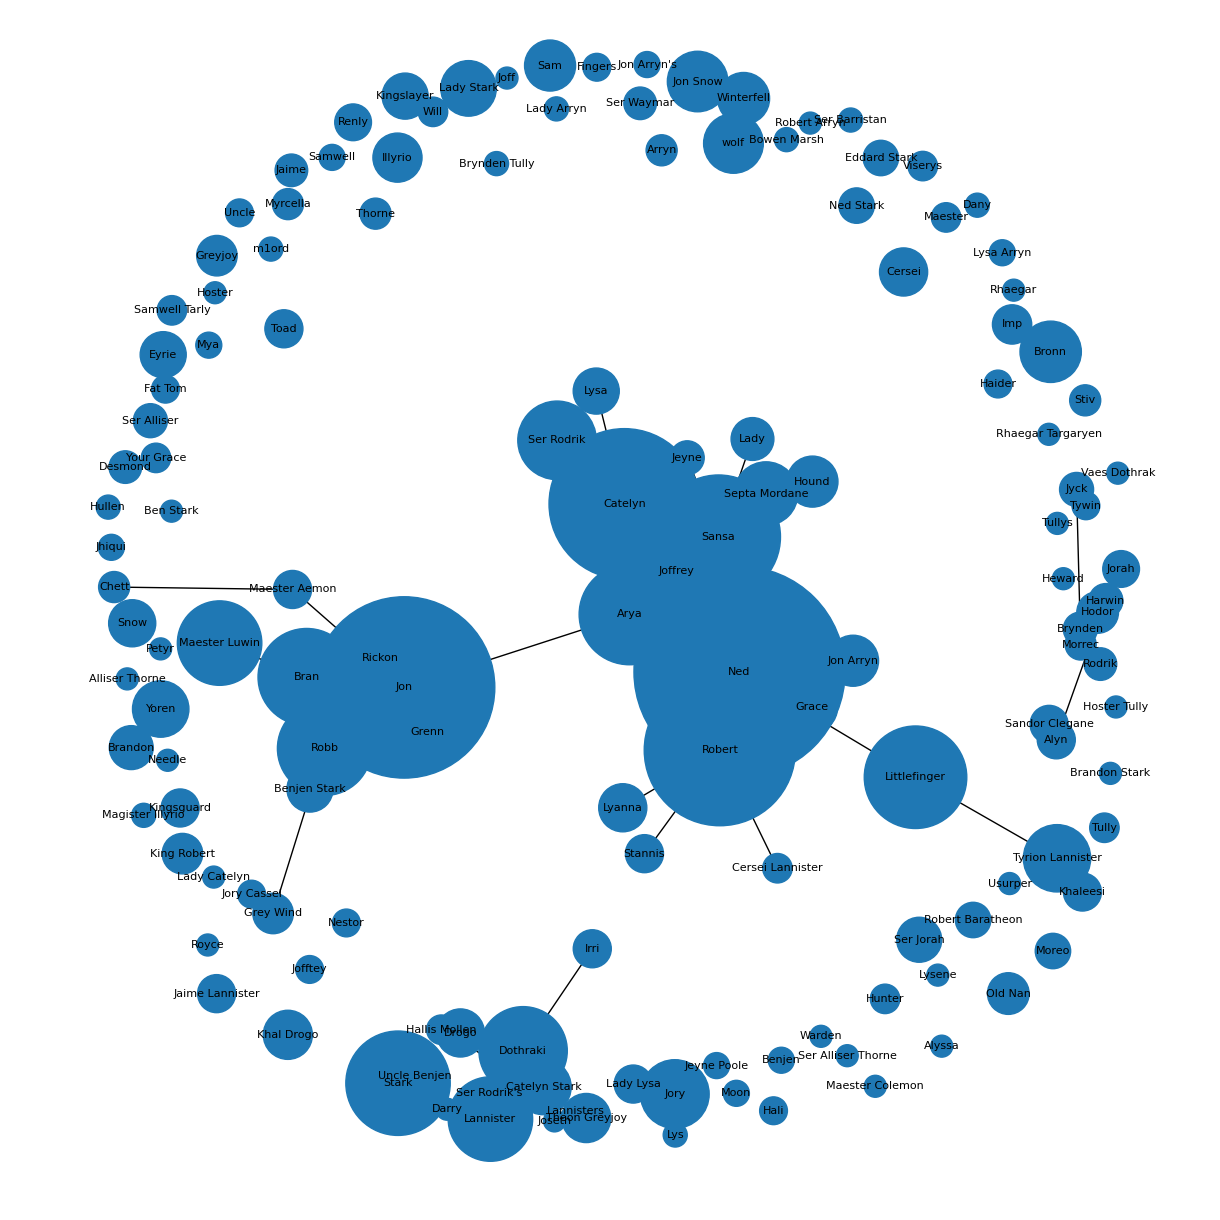

In [33]:
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.5)

nx.draw(
    G, pos,
    with_labels=True,
    node_size=[G.nodes[n]['weight'] * 50 for n in G.nodes],
    font_size=8
)

plt.show()

# Conclusiones

*   El proceso de Tokenización permite la clasificación de entidades en el texto. Lo que facilíta en análisis detallado de fragmentos de texto.
*   La identificación de patrones es clave en la identificación de secciones de texto con información específica requerida
* El NER utiliza modelos para entender el contexto de las entidades, lo que permite identificar personajes, lugares, fechas, entre otras cosas que ayuda a crear sistemas capaces de identificar relaciones, cómo el análisis de relación entre personajes que se planteó en el notebook
*   En el gráfico de nodos se evidencia inconsistencia en el análisis debido a que hay casos en que el mismo personaje se divide por nombre y apellido como si fueran personajes diferentes, para evitar esto sería necesario agregar un proceso de normalización de los nombres para obtener mejores resultados

